In [1]:
import tensorflow as tf
import numpy as np
from importlib import reload

%load_ext autoreload
%autoreload 2

from RLLSTM import * 
from cs231n.models.cnn import * 
from cs231n.data_feeder import CifarDataFeeder
from cs231n.data_utils import get_CIFAR10_data

df = CifarDataFeeder()
import pickle
import matplotlib.pyplot as plt

/Users/ruoxuan/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import itertools
import random

In [3]:
from baseline_NN import BaseNNModel

In [4]:
from sklearn import linear_model
import statsmodels.api as sm

/Users/ruoxuan/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
def all_models_reward(all_models_concat, filter_heights_reward, filter_widths_reward, num_filters_reward):
    
    model_rewards = list()
    max_num_layers = len(all_models_concat[0]) // 3
    for i in range(len(all_models_concat)):
        cur_model = all_models_concat[i]
        reward = 1
        for t in range(max_num_layers):
            reward *= filter_heights_reward[cur_model[3 * t + 0]] * filter_widths_reward[cur_model[3 * t + 1]] * num_filters_reward[cur_model[3 * t + 2]]
            
        model_rewards.append(reward)
    return model_rewards

def sample_model_reward(num_models, all_models_concat, filter_heights_reward, filter_widths_reward, num_filters_reward, reward_noise=0.1):
    
    models = list(); model_rewards = list()
    max_num_layers = len(all_models_concat[0]) // 3
    for i in range(num_models):
        cur_model = random.choice(all_models_concat)
        reward = np.random.uniform(low=(1-reward_noise), high=(1+reward_noise))
        for t in range(max_num_layers):
            reward *= filter_heights_reward[cur_model[3 * t + 0]] * filter_widths_reward[cur_model[3 * t + 1]] * num_filters_reward[cur_model[3 * t + 2]]
            
        models.append(cur_model); model_rewards.append(reward)
    return models, model_rewards

In [6]:
# lstm related
num_models = 100; max_num_layers = 2; num_filter_heights=3; num_filter_widths=3; num_num_filters = 3; lr = 1e-2; l2 = 0.001;
filter_heights=[1,3,7]; filter_widths=[1,3,7]; num_filters=[16,64,128];
filter_heights_reward = [0.90, 0.925, 0.95]; filter_widths_reward = [0.90, 0.925, 0.95]; num_filters_reward = [0.90, 0.925, 0.95]
# filter_heights_reward = [0.25, 0.5, 0.9]; filter_widths_reward = [0.25, 0.5, 0.9]; num_filters_reward = [0.25, 0.5, 0.9]
# rl_epochs = 3
hidden_dim = [10,10]

config = Config(num_models=num_models, max_num_layers=max_num_layers, num_filter_heights=num_filter_heights,
                num_filter_widths=num_filter_widths, num_num_filters = num_num_filters, l2=l2, lr=lr)


a = [[0,1,2], [0,1,2], [0,1,2]] * 2
all_models_concat = list(itertools.product(*a))
all_models_expected_reward = all_models_reward(all_models_concat, filter_heights_reward, filter_widths_reward, num_filters_reward)


base_NNmodel = BaseNNModel(config)
# base_model = BaseModel(config)
sess_base_NNmodel = tf.Session(graph=base_NNmodel.graph)
with base_NNmodel.graph.as_default():
    init = tf.global_variables_initializer()
sess_base_NNmodel.run(init)

In [7]:
loss_hist_base_model = list()
# num_models = 100;    
for epoch in range(200):
    models, model_rewards = sample_model_reward(num_models, all_models_concat, filter_heights_reward, filter_widths_reward, num_filters_reward, reward_noise=0.001)
    models_concat_feed_dict = {base_NNmodel.X_placeholder: models, base_NNmodel.R_placeholder: model_rewards}
    _, loss_base_model, pred = sess_base_NNmodel.run([base_NNmodel.train_op, base_NNmodel.loss, base_NNmodel.R_pred], models_concat_feed_dict)
    print("base model epoch {}, loss is {}".format(epoch, loss_base_model))
    loss_hist_base_model.append(loss_base_model)

base model epoch 0, loss is 2.1357502937316895
base model epoch 1, loss is 1.1806583404541016
base model epoch 2, loss is 0.6225876808166504
base model epoch 3, loss is 0.5181289911270142
base model epoch 4, loss is 0.357280969619751
base model epoch 5, loss is 0.3541059195995331
base model epoch 6, loss is 0.2867903709411621
base model epoch 7, loss is 0.22075243294239044
base model epoch 8, loss is 0.25134825706481934
base model epoch 9, loss is 0.2760157585144043
base model epoch 10, loss is 0.23450294137001038
base model epoch 11, loss is 0.25272002816200256
base model epoch 12, loss is 0.227983295917511
base model epoch 13, loss is 0.19438345730304718
base model epoch 14, loss is 0.20515300333499908
base model epoch 15, loss is 0.1786642223596573
base model epoch 16, loss is 0.1628304272890091
base model epoch 17, loss is 0.1619182676076889
base model epoch 18, loss is 0.1426374912261963
base model epoch 19, loss is 0.12365182489156723
base model epoch 20, loss is 0.15647873282432

In [8]:
print(np.corrcoef(np.squeeze(pred), model_rewards))

[[ 1.         -0.04083159]
 [-0.04083159  1.        ]]


In [9]:
X = sm.add_constant(all_models_concat)
y = sess_base_NNmodel.run([base_NNmodel.R_pred], {base_NNmodel.X_placeholder: all_models_concat})
y = np.squeeze(y)
print(np.corrcoef(all_models_expected_reward, y))

[[ 1.          0.51243809]
 [ 0.51243809  1.        ]]


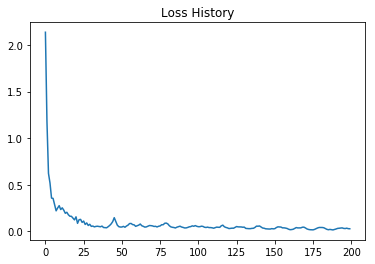

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(loss_hist_base_model)
plt.title('Loss History')
plt.show()

In [11]:
X = sm.add_constant(all_models_concat)
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.337
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     61.26
Date:                Fri, 15 Dec 2017   Prob (F-statistic):           2.32e-61
Time:                        21:26:11   Log-Likelihood:                 1142.1
No. Observations:                 729   AIC:                            -2270.
Df Residuals:                     722   BIC:                            -2238.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6466      0.006    108.775      0.0

In [12]:
X = sm.add_constant(all_models_concat)
mod = sm.OLS(all_models_expected_reward, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 9.878e+04
Date:                Fri, 15 Dec 2017   Prob (F-statistic):               0.00
Time:                        21:26:11   Log-Likelihood:                 3879.6
No. Observations:                 729   AIC:                            -7745.
Df Residuals:                     722   BIC:                            -7713.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5248      0.000   3773.433      0.0